In [8]:
import qiskit
print("qiskit version:", qiskit.__version__)

qiskit version: 1.4.0


In [40]:
from qiskit import IBMQ

#Save your IBM Quantum API token
IBMQ.save_account('a80d2cab0d6db0c274e192f348e18e6c40499d0f97008669e43bfb5db60e9084815b9cd4c8f06740e565a04e6e5a0fc09c39566a8fd79abe309f4ad77bedf432')

ImportError: cannot import name 'IBMQ' from 'qiskit' (c:\venv\Lib\site-packages\qiskit\__init__.py)

In [40]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
import numpy as np

# Function to create phase oracle
def phase_oracle(n, indices_to_mark, name='Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

# Optimization: using a dictionary to save created diffusers
diffuser_dict = {}
def diffuser(n):
    if n not in diffuser_dict:
        qc = QuantumCircuit(n, name='Diffuser')
        qc.h(range(n))
        qc.append(phase_oracle(n, [0]), range(n))
        qc.h(range(n))
        diffuser_dict[n] = qc
    return diffuser_dict[n]

# Grover's Algorithm Circuit
def Grover(n, indices_to_mark, r):
    qc = QuantumCircuit(n, n)
    qc.h(range(n))
    qc_oracle = phase_oracle(n, indices_to_mark)
    qc_diffuser = diffuser(n)
    for _ in range(r):
        qc.append(qc_oracle, range(n))
        qc.append(qc_diffuser, range(n))
    qc.measure(range(n), range(n))
    return qc

# Simulating Grover's Algorithm
def run_grover(n, indices_to_mark, r, shots=1024):
    sim = AerSimulator()
    sampler = SamplerV2()
    grover_circuit = Grover(n, indices_to_mark, r)
    grover_circuit = transpile(grover_circuit, sim, optimization_level=0)
    job = sampler.run([(grover_circuit, [])], shots=shots)  # Fixed incorrect sampler input format
    result = job.result()
    print(f"Grover's Algorithm Output: {result[0].data.c.get_counts()}")

# Example: Finding marked states in a 3-qubit system
run_grover(n=3, indices_to_mark=[2], r=1, shots=1024)

Grover's Algorithm Output: {'010': 797, '101': 35, '100': 30, '111': 37, '000': 29, '110': 39, '001': 30, '011': 27}


In [ ]:
import numpy as np
import time
import pandas as pd
import openpyxl
import os
from qiskit import QuantumCircuit, transpile

from Noise import QiskitNoiseModelDepol,QiskitNoiseModelBitflip, QiskitNoiseModelAmplitudeDamp
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator
from qiskit.utils.parallel import parallel_map
from qiskit_aer.noise import NoiseModel

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeMarrakesh

#
# Helper functions
#
def groverSuboptimalIterations(n, k):
    return int(np.round(0.58278 * np.sqrt(n / k)))

# n is the size of the database, m is the number of marked items
def grover_iterations(m, n):
    #return int(np.round(np.pi *(np.sqrt(n)/4)))

    num =int(np.round(np.pi / (4 * np.arcsin(np.sqrt(m / n))) - 1 / 2))
    if num<1:
        return 1
    else:
        return num

# selects n unique random numbers from in the range [0 - upper_bound)
def select_random_elements(upper_bound, n):
    elements = list(range(upper_bound))
    selected = []
    for i in range(n):
        index = np.random.randint(len(elements))
        selected.append(elements[index])
        del elements[index]
    return selected

# Checks if the integer representetion of binary_string exists in number_list
def binary_string_in_list(number_list, binary_string):
    num = int(binary_string, 2)
    return num in number_list

#
# Grover implementation
#

def phase_oracle(n, indicies_to_mark, name='Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indicies_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc


# Dynamic programming optimization of diffuser function
# dict to save dicts that have been computed 
diffuser_dict = {}

def diffuser(n):
    if n not in diffuser_dict:
        qc = QuantumCircuit(n, name='Diffuser')
        qc.h(range(n))
        qc.append(phase_oracle(n, [0]), range(n))
        qc.h(range(n))
        diffuser_dict.update({n: qc})
    return diffuser_dict.get(n)


def Grover(n, marked, r):
    qc = QuantumCircuit(n, n)
    qc.h(range(n))
    qc_phase = phase_oracle(n, marked)
    for _ in range(r):
        qc.append(qc_phase, range(n)) 
        qc.append(diffuser(n), range(n))
    qc.measure(range(n), range(n))
    return qc

#
# Functions to run experiments
#
def simulator_experiment_noise(n, noise_level):
    start = time.time()

    nums = range(1, int(np.floor((2**n) / 2)) + 1)

    results = parallel_map(experiment_parallel_noise, nums, task_args=([n, noise_level]), task_kwargs={}, num_processes=4)

    end = time.time()
    saving_data(n, noise_level, results)
    print(f"Time taken: {end - start:.2f} seconds")

def saving_data(n, noise_level, results):
    # Extract actual probabilities and oracle calls
    actual_probs = [f"{result[0]}" for result in results]
    oracle_calls = [f"{result[1]}" for result in results]
    nums = range(1, int(np.floor((2**n) / 2)) + 1)

    noise_type = "amp"  # Define noise type
    # Define Excel filename
    
    if (n <= 7):
        excel_filename = f"./noise_{noise_type}_1_to_7_qubits.xlsx"
    else:
        excel_filename = f"./noise_{noise_type}_{n}qubits.xlsx"

    # Create DataFrames for both probability and oracle calls data
    new_column = pd.DataFrame({
        f"{noise_level} noise level": actual_probs
    })
    oracle_calls_column = pd.DataFrame({
        f"{noise_level} noise level oracle calls": oracle_calls
    })

    # Check if file exists
    if os.path.exists(excel_filename):
        try:
            # Read existing data for probabilities
            with pd.ExcelFile(excel_filename) as excel:
                # Handle probability sheet
                if f"{n} qubits" in excel.sheet_names:
                    df = pd.read_excel(excel, sheet_name=f"{n} qubits")
                    if f"{noise_level} noise level" in df.columns:
                        print(f"⚠️ Column '{noise_level} noise level' already exists - overwriting")
                        df[f"{noise_level} noise level"] = new_column
                    else:
                        df = pd.concat([df, new_column], axis=1)
                else:
                    df = pd.DataFrame({"Number of Marked Items": nums})
                    df = pd.concat([df, new_column], axis=1)
                
                # Handle oracle calls sheet
                oracle_sheet_name = f"{n}qbit_oracle"
                if oracle_sheet_name in excel.sheet_names:
                    oracle_df = pd.read_excel(excel, sheet_name=oracle_sheet_name)
                    if f"{noise_level} noise level oracle calls" in oracle_df.columns:
                        print(f"⚠️ Column '{noise_level} noise level oracle calls' already exists - overwriting")
                        oracle_df[f"{noise_level} noise level oracle calls"] = oracle_calls_column
                    else:
                        oracle_df = pd.concat([oracle_df, oracle_calls_column], axis=1)
                else:
                    oracle_df = pd.DataFrame({"Number of Marked Items": nums})
                    oracle_df = pd.concat([oracle_df, oracle_calls_column], axis=1)
        except Exception as e:
            print(f"⚠️ Error reading existing file: {e}")
            df = pd.DataFrame({"Number of Marked Items": nums})
            df = pd.concat([df, new_column], axis=1)
            oracle_df = pd.DataFrame({"Number of Marked Items": nums})
            oracle_df = pd.concat([oracle_df, oracle_calls_column], axis=1)
    else:
        # File doesn't exist - create new
        df = pd.DataFrame({"Number of Marked Items": nums})
        df = pd.concat([df, new_column], axis=1)
        oracle_df = pd.DataFrame({"Number of Marked Items": nums})
        oracle_df = pd.concat([oracle_df, oracle_calls_column], axis=1)

    # Save back to Excel
    if os.path.exists(excel_filename):
        with pd.ExcelWriter(excel_filename, 
                          engine='openpyxl', 
                          mode='a',
                          if_sheet_exists='replace') as writer:
            # Save probability data
            df.to_excel(writer, index=False, sheet_name=f"{n} qubits")
            
            # Save oracle calls data
            oracle_df.to_excel(writer, index=False, sheet_name=f"{n}qbit_oracle")
            
            # Apply number formatting to both sheets
            for sheet_name, data_frame in [(f"{n} qubits", df), (f"{n}qbit_oracle", oracle_df)]:
                worksheet = writer.sheets[sheet_name]
                # Start from column 2 (B) since column 1 is "Number of Marked Items"
                for col in range(2, len(data_frame.columns) + 1):
                    for row in range(2, len(data_frame) + 2):  # +2 for header and 1-based index
                        worksheet.cell(row=row, column=col).number_format = '0.00'
    else:
        with pd.ExcelWriter(excel_filename, 
                          engine='openpyxl', 
                          mode='w') as writer:
            # Save probability data
            df.to_excel(writer, index=False, sheet_name=f"{n} qubits")
            
            # Save oracle calls data
            oracle_df.to_excel(writer, index=False, sheet_name=f"{n}qbit_oracle")
            
            # Apply number formatting to both sheets
            for sheet_name, data_frame in [(f"{n} qubits", df), (f"{n}qbit_oracle", oracle_df)]:
                worksheet = writer.sheets[sheet_name]
                for col in range(2, len(data_frame.columns) + 1):
                    for row in range(2, len(data_frame) + 2):
                        worksheet.cell(row=row, column=col).number_format = '0.00'
    
    print(f"✅ Results saved to {excel_filename}")
    print(f"  - Probability data in sheet '{n} qubits'")
    print(f"  - Oracle calls data in sheet '{n}qbit_oracle'")

def experiment_parallel_noise(nums, n, noise_level):
    print(f"started job {nums}")

    # how many grover iterations should be performed
    iterations = grover_iterations(nums, 2**n)
    
    #fake_backend = FakeMarrakesh()
    #noise_model = NoiseModel.from_backend(fake_backend)



    noise_instance = QiskitNoiseModelAmplitudeDamp(noise_level)
    #noise_instance = QiskitNoiseModelBitflip(single_qubit_error=0.01)
    #noise_instance = QiskitNoiseModelDepol(single_qubit_error=0.01)

    noise_model = noise_instance.get_noise_model()
    sim= AerSimulator(noise_model=noise_model)


    iterations_per_marked_item_set = 10
    shots = 10000

    hits = 0
    for j in range(iterations_per_marked_item_set):

        marked = select_random_elements(2**n, nums)
        qc = Grover(n, marked, iterations)
        t_qc = transpile(qc, sim)

        result = sim.run(t_qc, shots=shots, memory=True).result()
        counts = result.get_memory()
        for count in counts:
            found_correct_element = binary_string_in_list(marked, count)
            if found_correct_element:
                hits += 1
        print(f">>> Job {nums} finished iteration {j + 1} / {iterations_per_marked_item_set}")

    return ( ((hits / (iterations_per_marked_item_set * shots)) * 100), ((shots *iterations_per_marked_item_set)/ hits)*(iterations + 1))

#simulator_experiment(4)
for i in [0.002]:
    simulator_experiment_noise(2, i)
#simulator_experiment_noise(3, 0.000)

#for j in range(2, 10):
 #   for i in range(0, 10):
  #      simulator_experiment_noise(j, 0.0005*i)




#TESTs: med qbits 2 till 10
# inget noise
#testa fake backend Marrakech
#noise med marrakesh's min max (0.001, 0.003) vilket vi kör mellan 0.0005 och 0.005 ta 10 steg
#gör det för både optimistisk och pessimistisk grover

#antal test 8*(1+1+10)*2 = 176

#grafer:
# alla qbits
#optimistic grover, pessimistic grover:
#(ingetnoise, marrakesh, clasikal, min, max)

# antal grafer = 8 * 2  = 16

#tabbeller för datan för noise

started job 1
>>> Job 1 finished iteration 1 / 10
>>> Job 1 finished iteration 2 / 10
>>> Job 1 finished iteration 3 / 10
>>> Job 1 finished iteration 4 / 10
>>> Job 1 finished iteration 5 / 10
>>> Job 1 finished iteration 6 / 10
>>> Job 1 finished iteration 7 / 10
>>> Job 1 finished iteration 8 / 10
>>> Job 1 finished iteration 9 / 10
>>> Job 1 finished iteration 10 / 10
started job 2
>>> Job 2 finished iteration 1 / 10
>>> Job 2 finished iteration 2 / 10
>>> Job 2 finished iteration 3 / 10
>>> Job 2 finished iteration 4 / 10
>>> Job 2 finished iteration 5 / 10
>>> Job 2 finished iteration 6 / 10
>>> Job 2 finished iteration 7 / 10
>>> Job 2 finished iteration 8 / 10
>>> Job 2 finished iteration 9 / 10
>>> Job 2 finished iteration 10 / 10
✅ Results saved to ./noise_amp_1_to_7_qubits.xlsx
  - Probability data in sheet '2 qubits'
  - Oracle calls data in sheet '2qbit_oracle'
Time taken: 1.45 seconds


In [102]:

from qiskit.utils.parallel import parallel_map
from qiskit_aer.noise import NoiseModel

from qiskit_ibm_runtime.fake_provider import FakeMarrakesh

def get_backend_errors(backend):
    properties = backend.properties()
    error_data = {
        'single_qubit_gates': {},
        'two_qubit_gates': {},
        'readout_errors': [],
        't1_t2': []
    }
    
    # Single qubit gates
    for qubit in range(backend.configuration().n_qubits):
        error_data['single_qubit_gates'][qubit] = {
            'x': properties.gate_error('x', qubit),
            'sx': properties.gate_error('sx', qubit) if 'sx' in backend.configuration().basis_gates else None
        }
    
    # Readout errors
    for qubit in range(backend.configuration().n_qubits):
        error_data['readout_errors'].append(properties.readout_error(qubit))
    
    # T1 and T2 times
    for qubit in range(backend.configuration().n_qubits):
        error_data['t1_t2'].append({
            't1': properties.t1(qubit),
            't2': properties.t2(qubit)
        })
    
    return error_data

# Usage
error_rates = get_backend_errors(FakeMarrakesh())
print(error_rates)

{'single_qubit_gates': {0: {'x': 0.00025223688246143615, 'sx': 0.00025223688246143615}, 1: {'x': 0.00019830255735460014, 'sx': 0.00019830255735460014}, 2: {'x': 0.00013137253171934029, 'sx': 0.00013137253171934029}, 3: {'x': 0.00022244479476014138, 'sx': 0.00022244479476014138}, 4: {'x': 0.0006064256953297691, 'sx': 0.0006064256953297691}, 5: {'x': 0.00042656987685129124, 'sx': 0.00042656987685129124}, 6: {'x': 0.0003750787428597238, 'sx': 0.0003750787428597238}, 7: {'x': 0.00046006633147524756, 'sx': 0.00046006633147524756}, 8: {'x': 0.0005258471504367142, 'sx': 0.0005258471504367142}, 9: {'x': 0.0002827067615382236, 'sx': 0.0002827067615382236}, 10: {'x': 0.00034504624310974284, 'sx': 0.00034504624310974284}, 11: {'x': 0.0004347299607085589, 'sx': 0.0004347299607085589}, 12: {'x': 0.00013128314337937095, 'sx': 0.00013128314337937095}, 13: {'x': 0.0002347112969631167, 'sx': 0.0002347112969631167}, 14: {'x': 0.0001193824985857638, 'sx': 0.0001193824985857638}, 15: {'x': 0.0001278012167

In [101]:

from qiskit.utils.parallel import parallel_map
from qiskit_aer.noise import NoiseModel

from qiskit_ibm_runtime.fake_provider import FakeMarrakesh 

def analyze_gate_errors(backend):
    properties = backend.properties()
    gate_errors = []
    
    # Collect all gate errors
    for gate in properties.gates:
        if gate.gate == 'cx':
            # For CNOT gates
            for param in gate.parameters:
                if param.name == 'gate_error':
                    gate_errors.append(param.value)
        else:
            # For single-qubit gates
            for qubit in gate.qubits:
                gate_errors.append(properties.gate_error(gate.gate, qubit))
    
    # Calculate statistics
    if gate_errors:
        return {
            'min': np.min(gate_errors),
            'max': np.max(gate_errors),
            'median': np.median(gate_errors),
            'mean': np.mean(gate_errors),
            'count': len(gate_errors)
        }
    return None

# Usage
gate_stats = analyze_gate_errors(FakeMarrakesh())
print("\nGate Error Statistics:")
print(f"  Min: {gate_stats['min']:.4f}")
print(f"  Max: {gate_stats['max']:.4f}")
print(f"  Median: {gate_stats['median']:.4f}")

BackendPropertyError: 'Could not find the desired property for cz'

In [26]:
import qiskit
import qiskit_aer

print(qiskit.__version__)  # Should print 1.4.1
print(qiskit_aer.__version__)  # Should print a compatible version (e.g., 0.16.4)

1.4.2
0.16.4


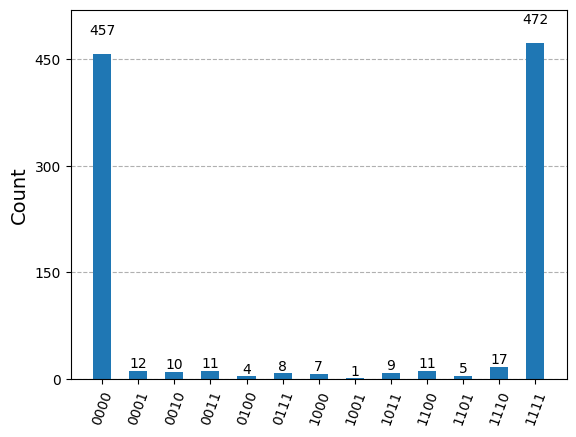

In [ ]:
import qiskit
from Noise import QiskitNoiseModel  # Import the noise model class

# Import necessary Qiskit modules
import qiskit_aer
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

# Create an instance of the noise model with realistic error rates
noise_instance = QiskitNoiseModel(single_qubit_error=0.02, two_qubit_error=0.05)

# Get the noise model for simulations
noise_model = noise_instance.get_noise_model()

# Define a quantum circuit with 4 qubits
circ = QuantumCircuit(4, 4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2, 3)
circ.measure([0, 1, 2, 3], [0, 1, 2, 3])

# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model)  # No need for basis_gates
transpiled_circuit = transpile(circ, backend)
result = backend.run(transpiled_circuit).result()

# Get and visualize results
counts = result.get_counts()
plot_histogram(counts)
